In [1]:
using Plots
using ColorSchemes
using LaTeXStrings
using LinearAlgebra
using ControlSystemsBase
using BehavioralSystems

In [2]:
n = 3
m = 2
p = 1
q = m+p
sys = drss(n,m,p)

StateSpace{Discrete{Float64}, Float64}
A = 
  -7.210226604154854  -3.54766080867243    -4.266221995883787
 -16.78956227327318   -8.666221273061119  -10.14654383022945
  27.43847854733309   14.005142905109174   16.499443300215965
B = 
  0.5441593227915431   0.2329749390655833
 -0.4961521001781674  -0.0
 -0.0                 -0.20579207406637412
C = 
 -0.07328380304705676  0.14573469420798618  0.0358002272342952
D = 
 0.0  -0.0

Sample Time: 1.0 (seconds)
Discrete-time state-space model

In [3]:
T = 10
Π = canonical_permutation(m,p,T)

ℬ_mb = ss2BT_modelbased(sys, nothing, T)
ℬ_1 = ℬ_mb[Π,:]
ℬ_2 = ss2BT_datadriven(sys, T)
ℬ_3 = ss2BT_hankel(sys, T)

30×23 Matrix{Float64}:
 -0.219182  -0.327335   -0.306808    0.0485544  …  -0.26989     0.168
 -0.157328  -0.152965   -0.080779   -0.207134       0.167024    0.0737814
  0.150816   0.0621368  -0.0467985   0.129496      -0.0342388   0.168744
 -0.212385   0.385495   -0.265353    0.116188      -0.16241     0.199019
 -0.152615   0.0750428  -0.221927   -0.0073823      0.312289    0.0842041
  0.158928   0.0219074   0.0687269   0.138264   …  -0.461498   -0.553755
 -0.219449  -0.415483   -0.0829167   0.222907      -0.127396    0.0789093
 -0.142382   0.0424951  -0.0480845   0.268225       0.0739744   0.0242074
  0.161021   0.0329802   0.151047    0.0644149     -0.288432    0.621315
 -0.229577   0.353967   -0.145005    0.0640932      0.153444    0.0281543
  ⋮                                             ⋱              
 -0.216603   0.259719    0.371898   -0.113125       0.158329    0.00827527
 -0.171323  -0.0681814  -0.0409059  -0.0591106     -0.126962   -0.00653458
  0.160737  -0.0451735  -0.0938

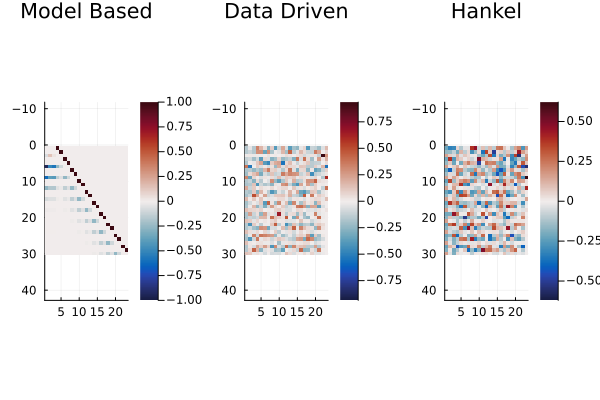

In [4]:
v1 = maximum(abs.(ℬ_1))
v2 = maximum(abs.(ℬ_2))
v3 = maximum(abs.(ℬ_3))
cmap = :balance
p1 = heatmap(ℬ_1, yflip=true, title="Model Based", 
color = cmap, clims=(-v1,v1), aspect_ratio=:equal)
p2 = heatmap(ℬ_2, yflip=true, title="Data Driven", 
color = cmap, clims=(-v2,v2), aspect_ratio=:equal)
p3 = heatmap(ℬ_3, yflip=true, title="Hankel", 
color = cmap, clims=(-v3,v3), aspect_ratio=:equal)
p_ = plot(p1, p2, p3, layout=(1,3))
savefig(p_, "ss2BT.pdf")
p_

In [5]:
rank(ℬ_1), rank(ℬ_2), rank(ℬ_3), T*m + n

(23, 23, 23, 23)

In [6]:
rank([ℬ_mb ℬ_2]), rank([ℬ_1 ℬ_3], atol=1e-10), rank([ℬ_1 ℬ_2], atol=1e-10), rank([ℬ_2 ℬ_3], atol=1e-10)

(30, 30, 30, 23)

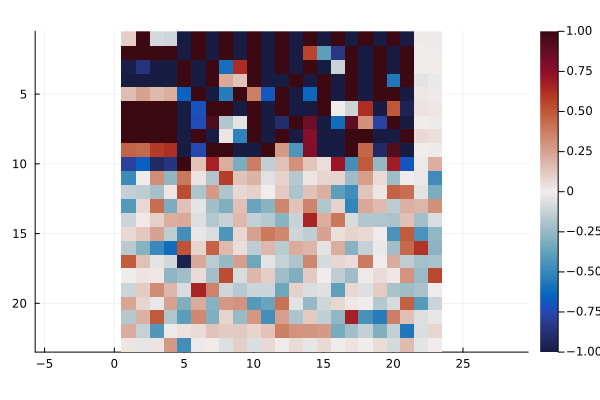

In [69]:
heatmap(ℬ_2' * ℬ_1, yflip=true, aspect_ratio=:equal, clims=(-1,1), color=cmap)

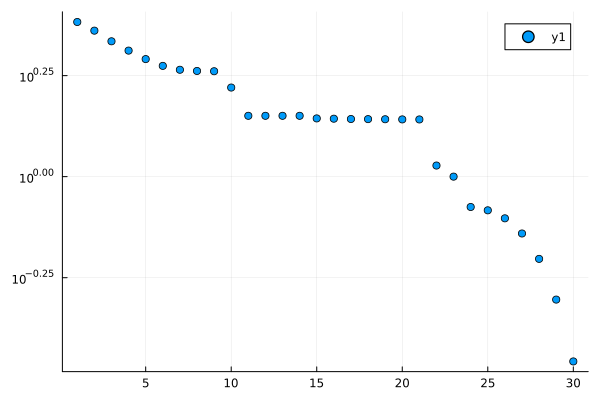

In [8]:
F = svd([ℬ_1 ℬ_2])
scatter(F.S, yscale=:log10)

In [7]:
BehavioralSystems._rank(F)

UndefVarError: UndefVarError: F not defined

In [7]:
d = zeros(T)
d_2 = zeros(T)
#d_3 = zeros(T)
w = random_trajectory(sys,5*T)
for t in 1:T
    d[t] = rank(ss2BT_modelbased(sys, nothing, t))
    d_2[t] = rank(ss2BT_hankel(w, t))
    #d_3[t] = rank(obsv(sys,t))
end

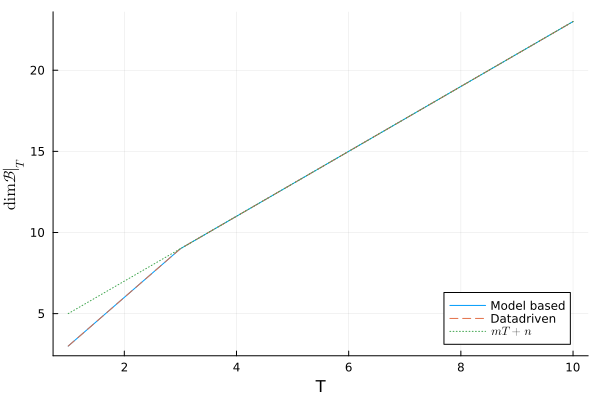

In [8]:
plot(d, 
label="Model based",
xlabel="T",
ylabel=L"\dim \mathcal{B}|_T",
)
#plot!(d_3, label="Observability Matrix")
plot!(d_2, label="Datadriven", linestyle=:dash)
plot!(1:10, n.+m.*(1:10), label=L"mT+n", linestyle=:dot)

In [9]:
lag_modelbased(sys), lag_datadriven(sys)

(3, 3)

In [10]:
w = random_trajectory(sys, 20)
ℓ = lag_datadriven(w)

3

In [11]:
R_mb = ss2r_modelbased(sys)
Π = canonical_permutation(m,p,ℓ+1)
R_1 = R_mb[:,Π]
R_2 = ss2r_datadriven(sys)

1×12 adjoint(::Matrix{Float64}) with eltype Float64:
 -0.00484568  0.000207283  …  -1.65547e-15  3.26703e-15  0.826998

In [12]:
w_ = random_trajectory(sys, ℓ+1)
R_mb * vec(w_), R_1 * vec(w_), R_2 * vec(w_)

([0.35359404687250223], [0.5642552192841064], [-8.432143872028064e-14])

In [13]:
complexity_datadriven(w)

(2, 3, 3)

In [53]:
complexity_mpum(w)

(1, 6, 3)

In [15]:
most_powerful_unfalsified_model(w)

0×3 adjoint(::Matrix{Float64}) with eltype Float64

In [40]:
T_ = 20
T_d = (m+1)*T_ + n+1
w_d = random_trajectory(sys, T_d)
w = random_trajectory(sys, T_)
w_h, N = data_interpolation(w_d, w; kernel=true)
N

43×0 Matrix{Float64}

In [17]:
norm(w-w_h)

2.903657141709827e-13

In [38]:
w_h_2 = data_interpolation(sys, w)
norm(w-w_h_2)

9.64816201495751e-13

In [39]:
S = ones(size(w))
S[:,15:end] .= 0.0
w_h_3 = data_interpolation(w_d, w; S=S)
norm(w-w_h_3)


3.9977971346193133

In [41]:
w_2 = w .+ 0.01*randn(size(w))
w_2h = data_interpolation(w_d, w_2)
norm(w-w_2), norm(w-w_2h)

(0.08703783633998168, 0.07237670646944755)

In [42]:
w_ini = w[:,1:10]
w_input = w[:,11:end]

w_s = data_simulation(w_d, w_ini, w_input, p)

norm(w-w_s)

1.7294517705058183e-13

In [27]:
imp = impulse(sys, 0:10)

ControlSystemsBase.SimResult{Array{Float64, 3}, UnitRange{Int64}, Array{Float64, 3}, Matrix{Float64}, StateSpace{Discrete{Float64}, Float64}}([0.0 -0.1121846392377906 … 0.0003325464368826758 0.00012063540622758693;;; 0.0 -0.02444069256397536 … 0.00014009152267976588 5.346247915489576e-5], 0:10, [0.0 0.5441593227915431 … 0.003077821812423262 0.0011816033499941272; 0.0 -0.4961521001781674 … 0.0065040701295645265 0.0024274557703509447; 0.0 0.0 … -0.010887298130548284 -0.004093178795435998;;; 0.0 0.2329749390655833 … 0.0012826994559727717 0.0005186151817871305; 0.0 0.0 … 0.002725444818797232 0.001070517097518174; 0.0 -0.20579207406637412 … -0.004555816062308982 -0.00180286313365087], [1.0 0.0 … 0.0 0.0], StateSpace{Discrete{Float64}, Float64}
A = 
  -7.210226604154854  -3.54766080867243    -4.266221995883787
 -16.78956227327318   -8.666221273061119  -10.14654383022945
  27.43847854733309   14.005142905109174   16.499443300215965
B = 
  0.5441593227915431   0.2329749390655833
 -0.4961521001

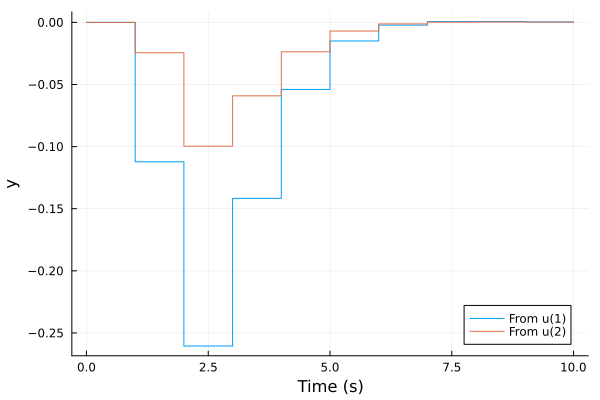

In [28]:
plot(imp)

In [29]:
imp.y

1×11×2 Array{Float64, 3}:
[:, :, 1] =
 0.0  -0.112185  -0.260533  -0.141685  …  0.000332546  0.000120635

[:, :, 2] =
 0.0  -0.0244407  -0.0996861  -0.0591375  …  0.000140092  5.34625e-5

In [31]:
y = impulse_response(w_d, 2, 11)

1×11×2 Array{Float64, 3}:
[:, :, 1] =
 -1.80411e-16  0.000771282  …  2.03755e-6  -1.0322e-5  -6.69878e-6

[:, :, 2] =
 1.5439e-16  -3.29931e-5  0.000135596  …  -8.71602e-8  4.41545e-7  2.86554e-7

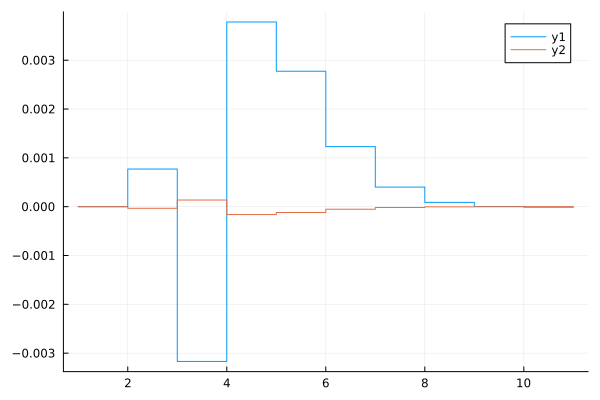

In [51]:
plot(y[1,:,:], lt= :steppost)

In [32]:
norm(y - imp.y)

0.3439355264181189

In [43]:
stp = step(sys, 10)

ControlSystemsBase.SimResult{Array{Float64, 3}, StepRangeLen{Float64, Base.TwicePrecision{Float64}, Base.TwicePrecision{Float64}, Int64}, Array{Float64, 3}, Matrix{Float64}, StateSpace{Discrete{Float64}, Float64}}([0.0 -0.1121846392377906 … -0.5840018902452903 -0.5838812548390537;;; 0.0 -0.02444069256397536 … -0.21466395754447493 -0.2146104950653224], 0.0:1.0:10.0, [0.0 0.5441593227915431 … -3.612349806345911 -3.61116820299587; 0.0 -0.4961521001781674 … -9.504333508768811 -9.501906052998324; 0.0 0.0 … 14.982656731482649 14.978563552687007;;; 0.0 0.2329749390655833 … -1.4146931886269465 -1.4141745734451783; 0.0 0.0 … -3.602454930622038 -3.6013844135245634; 0.0 -0.20579207406637412 … 5.772717916227456 5.770915053093879], [1.0 1.0 … 1.0 1.0], StateSpace{Discrete{Float64}, Float64}
A = 
  -7.210226604154854  -3.54766080867243    -4.266221995883787
 -16.78956227327318   -8.666221273061119  -10.14654383022945
  27.43847854733309   14.005142905109174   16.499443300215965
B = 
  0.544159322791

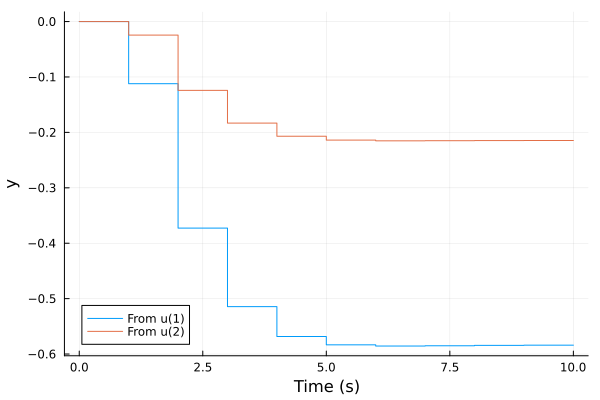

In [44]:
plot(stp)

In [48]:
stp.u

1×11 Matrix{Float64}:
 1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0

In [45]:
y_step = step_response(w_d, m, 11)

1×11×2 Array{Float64, 3}:
[:, :, 1] =
 5.13478e-16  -0.0769036  0.23907  …  -0.585926  -0.584897  -0.584229

[:, :, 2] =
 -7.14706e-16  -0.028266  0.0878705  …  -0.215358  -0.21498  -0.214734

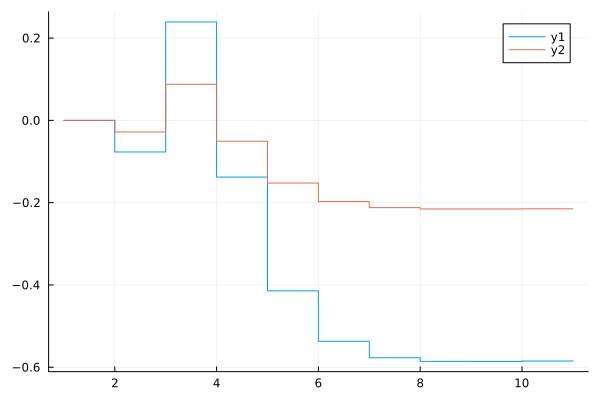

In [50]:
plot(y_step[1,:,:], lt= :steppost)

In [49]:
sys[:,1]

StateSpace{Discrete{Float64}, Float64}
A = 
  -7.210226604154854  -3.54766080867243    -4.266221995883787
 -16.78956227327318   -8.666221273061119  -10.14654383022945
  27.43847854733309   14.005142905109174   16.499443300215965
B = 
  0.5441593227915431
 -0.4961521001781674
 -0.0
C = 
 -0.07328380304705676  0.14573469420798618  0.0358002272342952
D = 
 0.0

Sample Time: 1.0 (seconds)
Discrete-time state-space model